### 导入相关库

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.style.use('default')
sns.set_palette('husl')

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


库导入完成！


### 加载数据

In [16]:
# 加载CSV数据
df = pd.read_csv('nyc_taxi_part_1_with_coords.csv')

# 查看数据基本信息
print(f'数据形状: {df.shape}')
print('\n前5行:')
print(df.head())

# print('\n列信息:')
# print(df.info())

# print('\n数据描述统计:')
# print(df.describe())

数据形状: (9885535, 24)

前5行:
   Unnamed: 0  vendorid     tpep_pickup_datetime    tpep_dropoff_datetime  \
0           0         2  2024-01-03T19:42:57.000  2024-01-03T20:15:55.000   
1           1         2  2024-01-03T18:43:26.000  2024-01-03T18:43:29.000   
2           2         2  2024-01-03T17:00:52.000  2024-01-03T17:01:05.000   
3           3         2  2024-01-03T10:00:04.000  2024-01-03T11:08:22.000   
4           4         2  2024-01-01T00:01:58.000  2024-01-01T00:10:04.000   

   passenger_count  trip_distance  ratecodeid store_and_fwd_flag  \
0              1.0          16.67         1.0                  N   
1              2.0           0.01         5.0                  N   
2              2.0           0.00         5.0                  N   
3              1.0          21.60         1.0                  N   
4              3.0           1.70         1.0                  N   

   pulocationid  dolocationid  payment_type  fare_amount  extra  mta_tax  \
0           132           

### 提取时间特征

In [17]:
# 时间特征提取

# 确认pickup_datetime列是datetime类型
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# 提取各种时间特征
df['hour'] = df['pickup_datetime'].dt.hour  # 小时 (0-23)
df['weekday'] = df['pickup_datetime'].dt.weekday  # 星期几 (0=周一, 6=周日)
df['day'] = df['pickup_datetime'].dt.day  # 日期
df['month'] = df['pickup_datetime'].dt.month  # 月份
df['year'] = df['pickup_datetime'].dt.year  # 年份
df['date'] = df['pickup_datetime'].dt.date  # 日期（不含时间）

# 显示时间特征统计
print(f"Data time range: {df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}")
print(f"\nHour distribution:")
print(df['hour'].value_counts().sort_index())
print(f"\nWeekday distribution (0=Monday, 6=Sunday):")
print(df['weekday'].value_counts().sort_index())

# 显示样本数据
print(df[['pickup_datetime', 'hour', 'weekday', 'day', 'month']].head())

Data time range: 2023-10-02 17:05:21 to 2024-01-03 19:42:57

Hour distribution:
hour
0     278298
1     187483
2     122409
3      82266
4      58074
5      57040
6     126716
7     260269
8     358720
9     407362
10    447102
11    493184
12    534966
13    548916
14    591322
15    614291
16    612444
17    677899
18    710123
19    637942
20    571529
21    568133
22    526844
23    412203
Name: count, dtype: int64

Weekday distribution (0=Monday, 6=Sunday):
weekday
0    1158867
1    1404931
2    1510307
3    1528103
4    1517295
5    1493756
6    1272276
Name: count, dtype: int64
      pickup_datetime  hour  weekday  day  month
0 2024-01-03 19:42:57    19        2    3      1
1 2024-01-03 18:43:26    18        2    3      1
2 2024-01-03 17:00:52    17        2    3      1
3 2024-01-03 10:00:04    10        2    3      1
4 2024-01-01 00:01:58     0        0    1      1


### 多维度时间分类

In [18]:

# 创建工作日/周末分类
# 周一到周五为工作日(0-4)，周六周日为周末(5-6)
df['is_weekend'] = df['weekday'].isin([5, 6])
df['day_type'] = df['is_weekend'].map({True: 'weekend', False: 'weekday'})

# 创建白天和晚上分类
# 白天：6-18，
# 晚上：18-6
df['is_daytime'] = (df['hour'] >= 6) & (df['hour'] < 18)
df['time_period'] = df['is_daytime'].map({True: 'day', False: 'night'})

# 创建组合分类
df['day_time_category'] = df['day_type'] + '_' + df['time_period']

# 显示分类统计
# 工作日，假期分类
print("\nWeekday/Weekend distribution:")
print(df['day_type'].value_counts())

# 白天，晚上分类
print("\nDay/Night distribution:")
print(df['time_period'].value_counts())

print("\nCombined category distribution:")
print(df['day_time_category'].value_counts())

# 显示各时间段的样本数据
print("\nSample data for each time period:")
for category in df['day_time_category'].unique():
    sample_data = df[df['day_time_category'] == category].head(2)
    print(f"\n{category}:")
    print(sample_data[['pickup_datetime', 'hour', 'weekday', 'day_type', 'time_period']].to_string())


Weekday/Weekend distribution:
day_type
weekday    7119503
weekend    2766032
Name: count, dtype: int64

Day/Night distribution:
time_period
day      5673191
night    4212344
Name: count, dtype: int64

Combined category distribution:
day_time_category
weekday_day      4210945
weekday_night    2908558
weekend_day      1462246
weekend_night    1303786
Name: count, dtype: int64

Sample data for each time period:

weekday_night:
      pickup_datetime  hour  weekday day_type time_period
0 2024-01-03 19:42:57    19        2  weekday       night
1 2024-01-03 18:43:26    18        2  weekday       night

weekday_day:
      pickup_datetime  hour  weekday day_type time_period
2 2024-01-03 17:00:52    17        2  weekday         day
3 2024-01-03 10:00:04    10        2  weekday         day

weekend_night:
      pickup_datetime  hour  weekday day_type time_period
6 2023-12-31 23:59:59    23        6  weekend       night
7 2023-12-31 23:59:59    23        6  weekend       night

weekend_day:
     

### 对比分析

In [21]:
# 多维度对比分析
# 按小时和分类统计订单量
hourly_stats = df.groupby(['hour', 'day_time_category']).size().reset_index(name='order_count')

# 创建透视表，便于分析
hourly_pivot = hourly_stats.pivot(index='hour', columns='day_time_category', values='order_count').fillna(0)

print("\nHourly order statistics by category:")
print(hourly_pivot)

# 1. 周末白天 vs 周末晚上对比
print("周末白天 vs 周末晚上对比")
weekend_day = hourly_pivot['weekend_day'] if 'weekend_day' in hourly_pivot.columns else pd.Series(0, index=hourly_pivot.index)
weekend_night = hourly_pivot['weekend_night'] if 'weekend_night' in hourly_pivot.columns else pd.Series(0, index=hourly_pivot.index)

print(f"Weekend day total orders: {weekend_day.sum()}")
print(f"Weekend night total orders: {weekend_night.sum()}")
print(f"Weekend day peak hour: {weekend_day.idxmax()} with {weekend_day.max()} orders")
print(f"Weekend night peak hour: {weekend_night.idxmax()} with {weekend_night.max()} orders")

# 2. 工作日白天 vs 工作日晚上对比
print("\n工作日白天 vs 工作日晚上对比 ")
weekday_day = hourly_pivot['weekday_day'] if 'weekday_day' in hourly_pivot.columns else pd.Series(0, index=hourly_pivot.index)
weekday_night = hourly_pivot['weekday_night'] if 'weekday_night' in hourly_pivot.columns else pd.Series(0, index=hourly_pivot.index)

print(f"Weekday day total orders: {weekday_day.sum()}")
print(f"Weekday night total orders: {weekday_night.sum()}")
print(f"Weekday day peak hour: {weekday_day.idxmax()} with {weekday_day.max()} orders")
print(f"Weekday night peak hour: {weekday_night.idxmax()} with {weekday_night.max()} orders")

# 3. 工作日 vs 周末整体对比
print("\n工作日 vs 周末整体对比")
weekday_total = weekday_day + weekday_night
weekend_total = weekend_day + weekend_night

print(f"Total weekday orders: {weekday_total.sum()}")
print(f"Total weekend orders: {weekend_total.sum()}")
print(f"Weekday peak hour: {weekday_total.idxmax()} with {weekday_total.max()} orders")
print(f"Weekend peak hour: {weekend_total.idxmax()} with {weekend_total.max()} orders")

# 计算平均每小时订单量
print("\n平均每小时订单量分析")
print(f"Weekend day average per hour: {weekend_day.mean():.2f}")
print(f"Weekend night average per hour: {weekend_night.mean():.2f}")
print(f"Weekday day average per hour: {weekday_day.mean():.2f}")
print(f"Weekday night average per hour: {weekday_night.mean():.2f}")

# 显示详细的小时分布对比
print("\n详细小时分布对比")
comparison_df = pd.DataFrame({
    'Hour': range(24),
    'Weekend_Day': weekend_day.values,
    'Weekend_Night': weekend_night.values,
    'Weekday_Day': weekday_day.values,
    'Weekday_Night': weekday_night.values,
    'Total_Weekend': weekend_total.values,
    'Total_Weekday': weekday_total.values
})

print(comparison_df.to_string(index=False))


Hourly order statistics by category:
day_time_category  weekday_day  weekday_night  weekend_day  weekend_night
hour                                                                     
0                          0.0       136327.0          0.0       141971.0
1                          0.0        67449.0          0.0       120034.0
2                          0.0        36836.0          0.0        85573.0
3                          0.0        24529.0          0.0        57737.0
4                          0.0        25471.0          0.0        32603.0
5                          0.0        42320.0          0.0        14720.0
6                     104648.0            0.0      22068.0            0.0
7                     225818.0            0.0      34451.0            0.0
8                     302605.0            0.0      56115.0            0.0
9                     319190.0            0.0      88172.0            0.0
10                    328978.0            0.0     118124.0            0.0


### 可视化图表

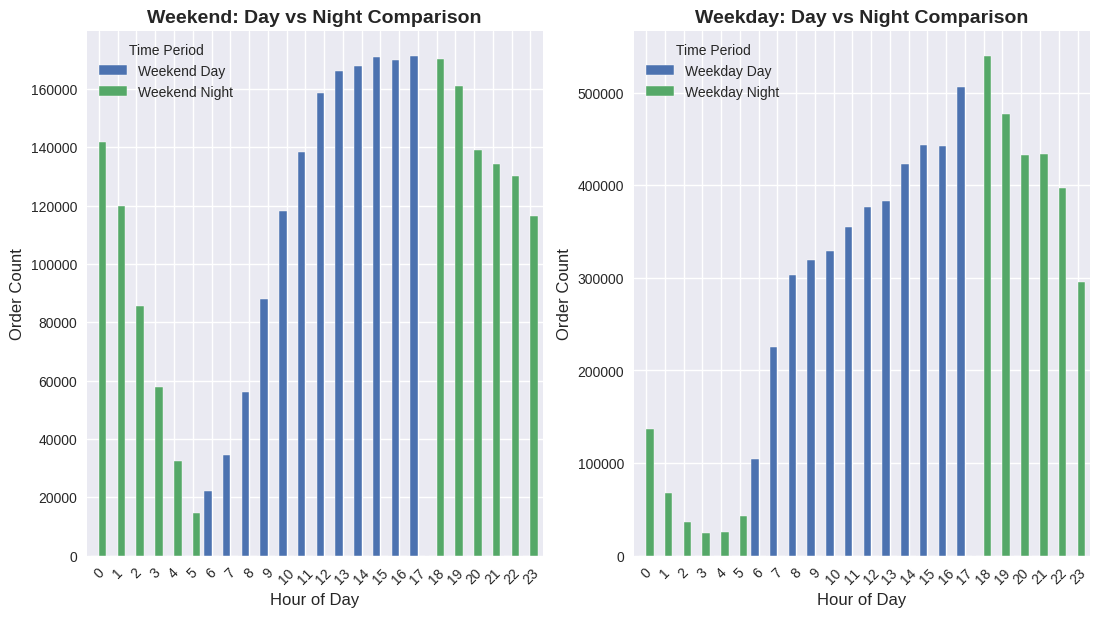

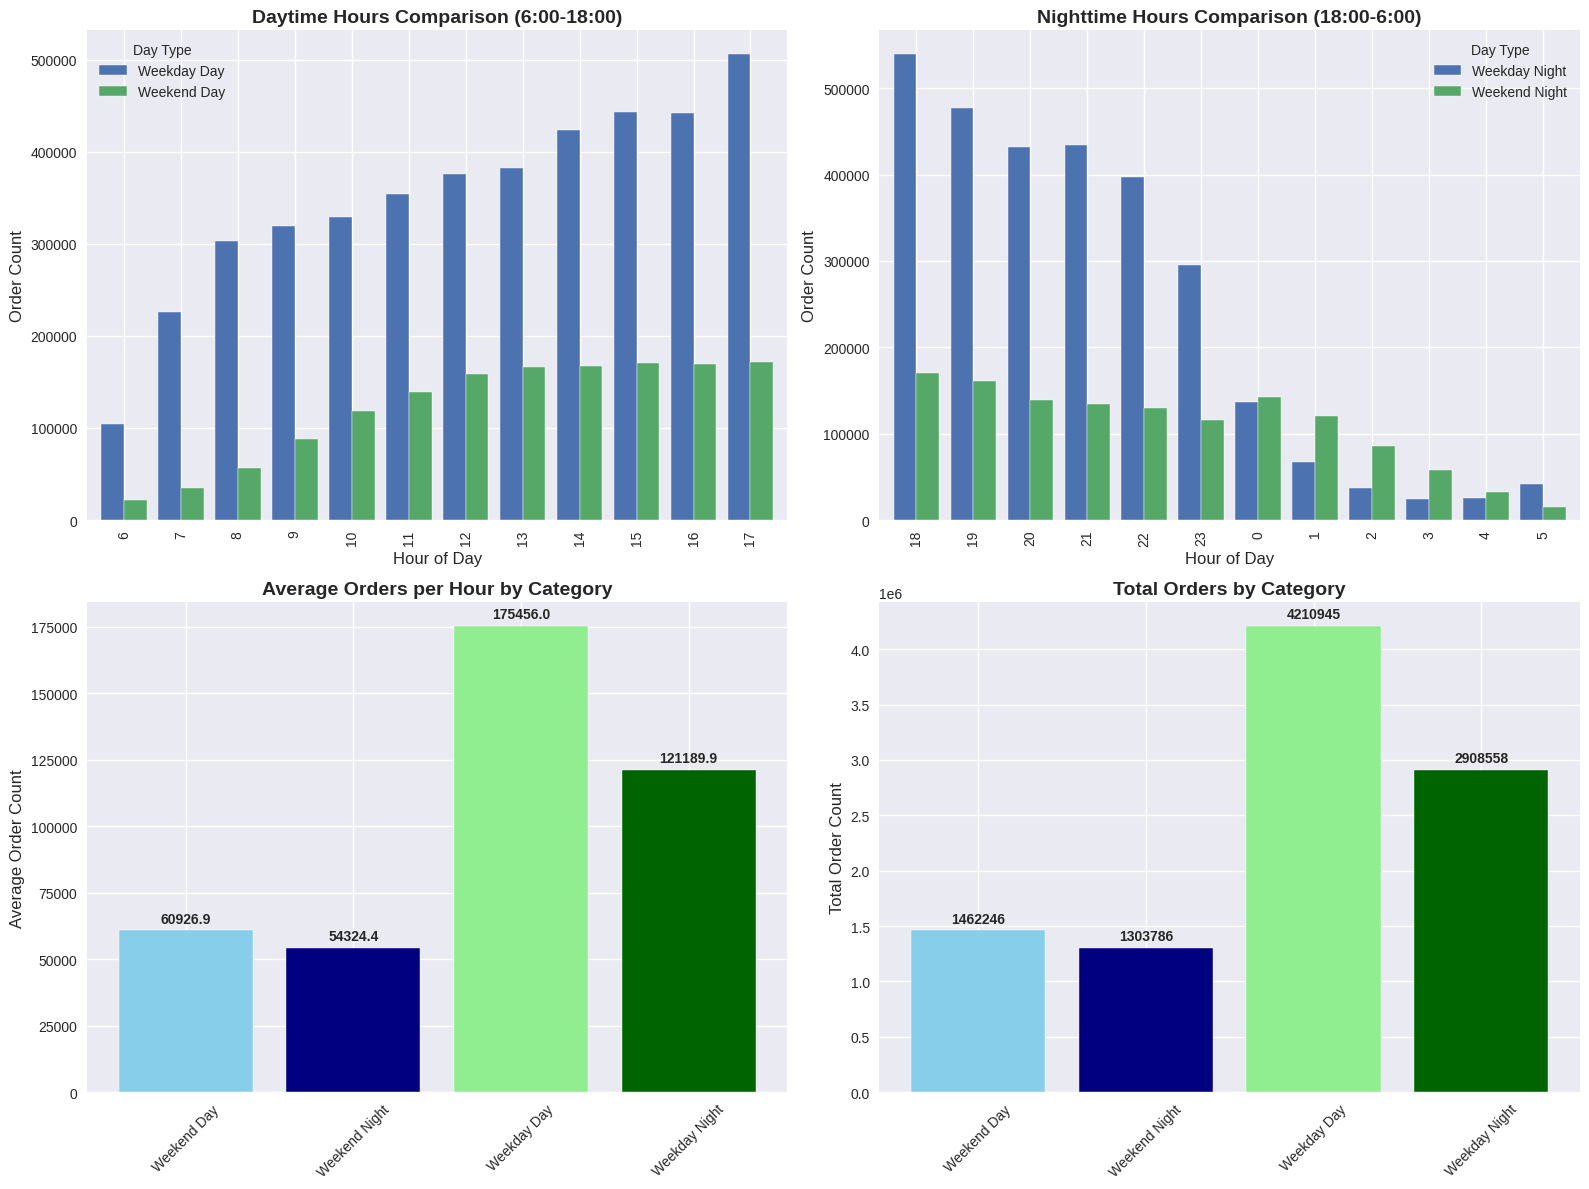

In [30]:
# 静态可视化图表

# 创建图表布局
fig = plt.figure(figsize=(20, 15))

# 周末白天vs晚上对比
ax2 = plt.subplot(2, 3, 2)
weekend_comparison = pd.DataFrame({
    'Weekend Day': weekend_day,
    'Weekend Night': weekend_night
})
weekend_comparison.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Weekend: Day vs Night Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Order Count', fontsize=12)
ax2.legend(title='Time Period')
ax2.tick_params(axis='x', rotation=45)

# 工作日白天vs晚上对比
ax3 = plt.subplot(2, 3, 3)
weekday_comparison = pd.DataFrame({
    'Weekday Day': weekday_day,
    'Weekday Night': weekday_night
})
weekday_comparison.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Weekday: Day vs Night Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.set_ylabel('Order Count', fontsize=12)
ax3.legend(title='Time Period')
ax3.tick_params(axis='x', rotation=45)

# 创建单独的详细对比图
fig2, ((ax7, ax8), (ax9, ax10)) = plt.subplots(2, 2, figsize=(16, 12))

# 白天时段对比（6-18）
day_hours = range(6, 18)
day_data = pd.DataFrame({
    'Weekday Day': [weekday_day[h] if h in weekday_day.index else 0 for h in day_hours],
    'Weekend Day': [weekend_day[h] if h in weekend_day.index else 0 for h in day_hours]
}, index=day_hours)
day_data.plot(kind='bar', ax=ax7, width=0.8)
ax7.set_title('Daytime Hours Comparison (6:00-18:00)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Hour of Day', fontsize=12)
ax7.set_ylabel('Order Count', fontsize=12)
ax7.legend(title='Day Type')

# 晚上时段对比（18-6）
night_hours = list(range(18, 24)) + list(range(0, 6))
night_data = pd.DataFrame({
    'Weekday Night': [weekday_night[h] if h in weekday_night.index else 0 for h in night_hours],
    'Weekend Night': [weekend_night[h] if h in weekend_night.index else 0 for h in night_hours]
}, index=night_hours)
night_data.plot(kind='bar', ax=ax8, width=0.8)
ax8.set_title('Nighttime Hours Comparison (18:00-6:00)', fontsize=14, fontweight='bold')
ax8.set_xlabel('Hour of Day', fontsize=12)
ax8.set_ylabel('Order Count', fontsize=12)
ax8.legend(title='Day Type')

# 平均订单量对比
categories = ['Weekend Day', 'Weekend Night', 'Weekday Day', 'Weekday Night']
avg_orders = [weekend_day.mean(), weekend_night.mean(), weekday_day.mean(), weekday_night.mean()]
colors = ['skyblue', 'navy', 'lightgreen', 'darkgreen']
ax9.bar(categories, avg_orders, color=colors)
ax9.set_title('Average Orders per Hour by Category', fontsize=14, fontweight='bold')
ax9.set_ylabel('Average Order Count', fontsize=12)
ax9.tick_params(axis='x', rotation=45)

# 在柱状图上添加数值标签
for i, v in enumerate(avg_orders):
    ax9.text(i, v + max(avg_orders)*0.01, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# 总订单量对比
total_orders = [weekend_day.sum(), weekend_night.sum(), weekday_day.sum(), weekday_night.sum()]
ax10.bar(categories, total_orders, color=colors)
ax10.set_title('Total Orders by Category', fontsize=14, fontweight='bold')
ax10.set_ylabel('Total Order Count', fontsize=12)
ax10.tick_params(axis='x', rotation=45)

# 在柱状图上添加数值标签
for i, v in enumerate(total_orders):
    ax10.text(i, v + max(total_orders)*0.01, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### 交互式图表

In [35]:
# 交互式图表

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# 24小时订单量对比交互式线图
fig1 = go.Figure()

# 添加各个分类的线条
for column in hourly_pivot.columns:
    if hourly_pivot[column].sum() > 0:  # 只显示有数据的分类
        fig1.add_trace(go.Scatter(
            x=hourly_pivot.index,
            y=hourly_pivot[column],
            mode='lines+markers',
            name=column.replace('_', ' ').title(),
            line=dict(width=3),
            marker=dict(size=8),
            hovertemplate='<b>%{fullData.name}</b><br>' +
                         'Hour: %{x}<br>' +
                         'Orders: %{y}<br>' +
                         '<extra></extra>'
        ))

fig1.update_layout(
    title={
        'text': 'NYC Taxi Orders: 24-Hour Interactive Comparison',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'family': 'Arial, sans-serif'}
    },
    xaxis_title='Hour of Day',
    yaxis_title='Order Count',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=2,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    width=1000,
    height=600
)

fig1.show()

# 子图布局：多维度对比
fig2 = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Weekend: Day vs Night',
        'Weekday: Day vs Night',
        'Overall: Weekday vs Weekend',
        'Average Orders per Hour by Category'
    ),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"type": "bar"}]]
)

# 周末白天vs晚上
fig2.add_trace(
    go.Scatter(x=list(range(24)), y=weekend_day.values,
               mode='lines+markers', name='Weekend Day',
               line=dict(color='skyblue', width=3)),
    row=1, col=1
)
fig2.add_trace(
    go.Scatter(x=list(range(24)), y=weekend_night.values,
               mode='lines+markers', name='Weekend Night',
               line=dict(color='navy', width=3)),
    row=1, col=1
)

# 工作日白天vs晚上
fig2.add_trace(
    go.Scatter(x=list(range(24)), y=weekday_day.values,
               mode='lines+markers', name='Weekday Day',
               line=dict(color='lightgreen', width=3)),
    row=1, col=2
)
fig2.add_trace(
    go.Scatter(x=list(range(24)), y=weekday_night.values,
               mode='lines+markers', name='Weekday Night',
               line=dict(color='darkgreen', width=3)),
    row=1, col=2
)

fig2.show()

# 热力图（交互式）
fig3 = go.Figure(data=go.Heatmap(
    z=hourly_pivot.T.values,
    x=hourly_pivot.index,
    y=hourly_pivot.columns,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='<b>Category:</b> %{y}<br>' +
                  '<b>Hour:</b> %{x}<br>' +
                  '<b>Orders:</b> %{z}<br>' +
                  '<extra></extra>'
))

fig3.update_layout(
    title={
        'text': 'Interactive Heatmap: Order Distribution by Hour and Category',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title='Hour of Day',
    yaxis_title='Category',
    width=1000,
    height=500
)

fig3.show()

# 3D表面图显示订单分布
fig4 = go.Figure(data=[go.Surface(
    z=hourly_pivot.T.values,
    x=hourly_pivot.index,
    y=list(range(len(hourly_pivot.columns))),
    colorscale='Viridis',
    hovertemplate='<b>Hour:</b> %{x}<br>' +
                  '<b>Category Index:</b> %{y}<br>' +
                  '<b>Orders:</b> %{z}<br>' +
                  '<extra></extra>'
)])

fig4.update_layout(
    title={
        'text': '3D Surface Plot: Order Volume Distribution',
        'x': 0.5,
        'xanchor': 'center'
    },
    scene=dict(
        xaxis_title='Hour of Day',
        yaxis_title='Category Index',
        zaxis_title='Order Count'
    ),
    width=1000,
    height=700
)

fig4.show()


### 24小时订单量分布图

In [40]:


# 计算每小时的订单量
hourly_orders = df.groupby('hour').size().reset_index(name='order_count')
print(hourly_orders)


# 交互式折线图
fig_line = go.Figure()

fig_line.add_trace(go.Scatter(
    x=hourly_orders['hour'],
    y=hourly_orders['order_count'],
    mode='lines+markers',
    name='订单量趋势',
    line=dict(color='red', width=3),
    marker=dict(size=8, color='darkred'),
    hovertemplate='<b>时间</b>: %{x}:00<br>' +
                  '<b>订单量</b>: %{y}<br>' +
                  '<extra></extra>'
))

fig_line.update_layout(
    title={
        'text': '24小时订单量趋势图',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis_title='小时 (0-23)',
    yaxis_title='订单数量',
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        range=[-0.5, 23.5]
    ),
    template='plotly_white',
    height=500
)

fig_line.show()

# 分析高峰和低谷时段
max_hour = hourly_orders.loc[hourly_orders['order_count'].idxmax()]
min_hour = hourly_orders.loc[hourly_orders['order_count'].idxmin()]

print(f"订单高峰时段: {max_hour['hour']}:00 - 订单量: {max_hour['order_count']}")
print(f"订单低谷时段: {min_hour['hour']}:00 - 订单量: {min_hour['order_count']}")
print(f"高峰与低谷差值: {max_hour['order_count'] - min_hour['order_count']}")
print(f"平均每小时订单量: {hourly_orders['order_count'].mean():.1f}")

# 找出高于平均值的时段
avg_orders = hourly_orders['order_count'].mean()
high_demand_hours = hourly_orders[hourly_orders['order_count'] > avg_orders]['hour'].tolist()
low_demand_hours = hourly_orders[hourly_orders['order_count'] <= avg_orders]['hour'].tolist()

print(f"\n高需求时段 (高于平均值): {high_demand_hours}")
print(f"低需求时段 (低于或等于平均值): {low_demand_hours}")

# 创建极坐标图（24小时时钟样式）
fig_polar = go.Figure()

# 将小时转换为角度 (0小时在顶部)
angles = [(hour * 15 - 90) % 360 for hour in hourly_orders['hour']]

fig_polar.add_trace(go.Scatterpolar(
    r=hourly_orders['order_count'],
    theta=hourly_orders['hour'] * 15,  # 每小时15度
    mode='lines+markers',
    name='订单量',
    line=dict(color='blue', width=3),
    marker=dict(size=8, color='red'),
    hovertemplate='<b>时间</b>: %{theta}:00<br>' +
                  '<b>订单量</b>: %{r}<br>' +
                  '<extra></extra>'
))

fig_polar.update_layout(
    title={
        'text': '24小时订单量分布 - 时钟视图',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(hourly_orders['order_count']) * 1.1]
        ),
        angularaxis=dict(
            tickmode='array',
            tickvals=list(range(0, 360, 15)),
            ticktext=[f'{i}h' for i in range(24)],
            direction='clockwise',
            period=360
        )
    ),
    height=600
)

fig_polar.show()

    hour  order_count
0      0       278298
1      1       187483
2      2       122409
3      3        82266
4      4        58074
5      5        57040
6      6       126716
7      7       260269
8      8       358720
9      9       407362
10    10       447102
11    11       493184
12    12       534966
13    13       548916
14    14       591322
15    15       614291
16    16       612444
17    17       677899
18    18       710123
19    19       637942
20    20       571529
21    21       568133
22    22       526844
23    23       412203


订单高峰时段: 18:00 - 订单量: 710123
订单低谷时段: 5:00 - 订单量: 57040
高峰与低谷差值: 653083
平均每小时订单量: 411897.3

高需求时段 (高于平均值): [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
低需求时段 (低于或等于平均值): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Analysis:


### **Weekend Order Pattern Analysis:**

* **A nighttime order peak appears around midnight (0:00), exceeding 140,000 orders**, indicating that people tend to use taxis heavily after weekend nightlife activities such as parties and entertainment.

* **Orders gradually decrease between 1:00 AM and 3:00 AM**, but still remain higher than during the same hours on weekdays.

* **Another peak occurs from late morning to early afternoon (9:00 AM to 2:00 PM), with order volumes around 160,000**, likely reflecting weekend travel demand for shopping, socializing, and leisure activities.

* **Order volumes rise again after 6:00 PM**, although the evening peak is lower than the midnight level.


---
### **Weekday Order Pattern Analysis**:

* **Order volumes during the early morning hours (0:00–5:00 AM) are significantly lower than on weekends**, with counts falling below 100,000—representing the lowest levels of the day.

* **From 6:00 AM onward, order volumes rise rapidly**, reaching the **morning peak between 8:00 and 9:00 AM**.

* **The highest demand is concentrated between noon and late afternoon (12:00 PM to 4:00 PM)**, with peak order volumes exceeding **500,000 orders**.

* **After 6:00 PM (typical off-work hours), order volumes remain high**, though **the peak is lower than that of the afternoon period**.

* **Evening orders (after 7:00 PM) are still considerable**, but **gradually decline after 8:00 PM**.
